# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Inference Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new data for final predictions.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for the weather measures and calendar. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar, electricity_prices 

# We go back into the notebooks folder
%cd pipeline

/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project
/Users/tobiasmjensen/Documents/aau_bds/m7_second-semester-project/bds_m7_second-semester-project/pipeline


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> 📮 Retrieving Model from Model Registry

In [4]:
# Importing joblib to load the model
import joblib

# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="xgb_electricity_price_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Downloading the saved models to local directories
saved_model_dir = retrieved_model.download()

# Loading the saved XGBoost Regressor models
retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgb_electricity_price_model.pkl")

In [6]:
# Display the retrieved XGBoost Regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as new data to make predictions.

In [7]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark(
    freq='H',
)

# Fetching the moving average of the electricity prices
electricity_price_window_df = electricity_prices.electricity_prices_window(
    historical=False,
    area=["DK1"],
)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [8]:
# Merging the weather forecast and electricity price window dataframes
new_data = pd.merge(electricity_price_window_df, weather_forecast_df, how='inner', left_on='timestamp', right_on='timestamp')

In [9]:
# Merging the new data and calendar dataframes
new_data = pd.merge(new_data, calendar_df, how='inner', left_on='timestamp', right_on='timestamp')

# Displaying the new data
new_data.tail()

,timestamp,datetime_x,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,datetime_y,date_x,...,wind_speed_10m,wind_gusts_10m,datetime,date_y,hour_y,dayofweek,day,month,year,workday
115,1717009200000,2024-05-29 19:00:00,0.721492,0.406411,0.402004,0.450691,0.419463,0.428446,2024-05-29 19:00:00,2024-05-29,...,16.5,33.1,2024-05-29 19:00:00,2024-05-29,19,2,29,5,2024,1
116,1717012800000,2024-05-29 20:00:00,0.715665,0.407001,0.402057,0.449774,0.419203,0.428305,2024-05-29 20:00:00,2024-05-29,...,16.5,33.8,2024-05-29 20:00:00,2024-05-29,20,2,29,5,2024,1
117,1717016400000,2024-05-29 21:00:00,0.712467,0.407648,0.402324,0.449189,0.419090,0.428216,2024-05-29 21:00:00,2024-05-29,...,16.9,34.2,2024-05-29 21:00:00,2024-05-29,21,2,29,5,2024,1
118,1717020000000,2024-05-29 22:00:00,0.711827,0.408310,0.402648,0.448863,0.419058,0.428135,2024-05-29 22:00:00,2024-05-29,...,17.4,36.0,2024-05-29 22:00:00,2024-05-29,22,2,29,5,2024,1
119,1717023600000,2024-05-29 23:00:00,0.713018,0.409061,0.403081,0.448631,0.419063,0.428069,2024-05-29 23:00:00,2024-05-29,...,18.2,38.2,2024-05-29 23:00:00,2024-05-29,23,2,29,5,2024,1


In [10]:
# Dropping and renaming columns for the new data with weather forecast and calendar
new_data.drop(columns=['datetime_y', 'hour_y', 'date_y','datetime_x'], inplace=True)
new_data.rename(columns={
    'date_x': 'date', 
    'hour_x': 'hour'}, inplace=True)

# Displaying the new data
new_data.tail()

,timestamp,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,date,hour,temperature_2m,...,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,datetime,dayofweek,day,month,year,workday
115,1717009200000,0.721492,0.406411,0.402004,0.450691,0.419463,0.428446,2024-05-29,19,15.4,...,61.0,97.0,16.5,33.1,2024-05-29 19:00:00,2,29,5,2024,1
116,1717012800000,0.715665,0.407001,0.402057,0.449774,0.419203,0.428305,2024-05-29,20,15.3,...,61.0,98.0,16.5,33.8,2024-05-29 20:00:00,2,29,5,2024,1
117,1717016400000,0.712467,0.407648,0.402324,0.449189,0.419090,0.428216,2024-05-29,21,15.1,...,61.0,100.0,16.9,34.2,2024-05-29 21:00:00,2,29,5,2024,1
118,1717020000000,0.711827,0.408310,0.402648,0.448863,0.419058,0.428135,2024-05-29,22,14.6,...,61.0,100.0,17.4,36.0,2024-05-29 22:00:00,2,29,5,2024,1
119,1717023600000,0.713018,0.409061,0.403081,0.448631,0.419063,0.428069,2024-05-29,23,14.0,...,61.0,100.0,18.2,38.2,2024-05-29 23:00:00,2,29,5,2024,1


To make predictions based on the new date, we must match it to the schema of the training data. We start by sorting the training data retrieved from the feature store based on the timestamp and then use the append method in Pandas to concatenate the two DataFrames. After combining the dataframes we can add columns of moving windows to the combined data to match the schema of the training data.

In [11]:
# Relocate columns to match training data schema
forecast_data = new_data[['hour', 'prev_1w_mean', 'prev_2w_mean', 'prev_4w_mean', 'prev_6w_mean',
       'prev_8w_mean', 'prev_12w_mean', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'rain', 'snowfall',
       'weather_code', 'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m',
       'dayofweek', 'day', 'month', 'year', 'workday']]

In [12]:
# Display the first few rows of the DataFrame 'forecast_data'
forecast_data.head()

,hour,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,temperature_2m,relative_humidity_2m,precipitation,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,0,0.483995,0.340337,0.396817,0.440260,0.419892,0.432834,13.1,88.0,0.0,...,0.0,1.0,24.0,2.9,5.0,5,25,5,2024,0
1,1,0.485406,0.339550,0.396420,0.440505,0.419882,0.432842,12.4,85.0,0.0,...,0.0,1.0,42.0,5.0,8.3,5,25,5,2024,0
2,2,0.486800,0.338797,0.396047,0.440800,0.419868,0.432849,11.9,84.0,0.0,...,0.0,1.0,22.0,4.3,7.6,5,25,5,2024,0
3,3,0.488181,0.337964,0.395646,0.441108,0.419853,0.432859,11.7,85.0,0.0,...,0.0,2.0,67.0,4.0,7.9,5,25,5,2024,0
4,4,0.489582,0.337203,0.395259,0.441418,0.419836,0.432871,11.5,85.0,0.0,...,0.0,2.0,68.0,3.2,6.1,5,25,5,2024,0


## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures.

In [13]:
# Make predictions using the retrieved XGBoost model on the 'forecast_data'
# The 'predict' method is called on the 'retrieved_xgboost_model' object, passing 'forecast_data' as input
predictions = retrieved_xgboost_model.predict(forecast_data)

# Print predictions
print(predictions)

[ 0.37044442  0.33768535  0.31259432  0.30129606  0.30129606  0.2905136
  0.36638936  0.3602207   0.30875593  0.31091535  0.24433768  0.19817692
  0.18494225  0.09481517 -0.06090647  0.01700713  0.13709255  0.25278217
  0.36873132  0.46317428  0.5006815   0.42743158  0.46669316  0.4434585
  0.39237446  0.3339665   0.37341693  0.3309047   0.32585466  0.29005465
  0.3854071   0.26165003  0.24604388  0.2392486   0.17993116  0.14188087
  0.09917814 -0.08087895  0.10925199  0.11336661  0.17502254  0.38088852
  0.50950557  0.49918467  0.64970505  0.4632262   0.5429997   0.5537365
  0.51497746  0.47374332  0.47105494  0.48747465  0.49391243  0.503284
  0.6577244   0.72089833  0.72843945  0.75672954  0.6398077   0.601829
  0.5430486   0.5017259   0.4871386   0.5161101   0.57549506  0.65319824
  0.7484515   0.7663132   0.7561885   0.68000174  0.66949546  0.5804552
  0.47924474  0.47754726  0.45169386  0.4499464   0.43647784  0.5241808
  0.6752391   0.73304135  0.7262753   0.68579215  0.6179405 

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [14]:
# Assign the predictions info the dataframe
new_data['predictions'] = predictions

# Show the dataframe with the predictions
new_data[['datetime', 'predictions']]

,datetime,predictions
0,2024-05-25 00:00:00,0.370444
1,2024-05-25 01:00:00,0.337685
2,2024-05-25 02:00:00,0.312594
3,2024-05-25 03:00:00,0.301296
4,2024-05-25 04:00:00,0.301296
...,...,...
115,2024-05-29 19:00:00,0.760141
116,2024-05-29 20:00:00,0.780643
117,2024-05-29 21:00:00,0.716156
118,2024-05-29 22:00:00,0.631320


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization.

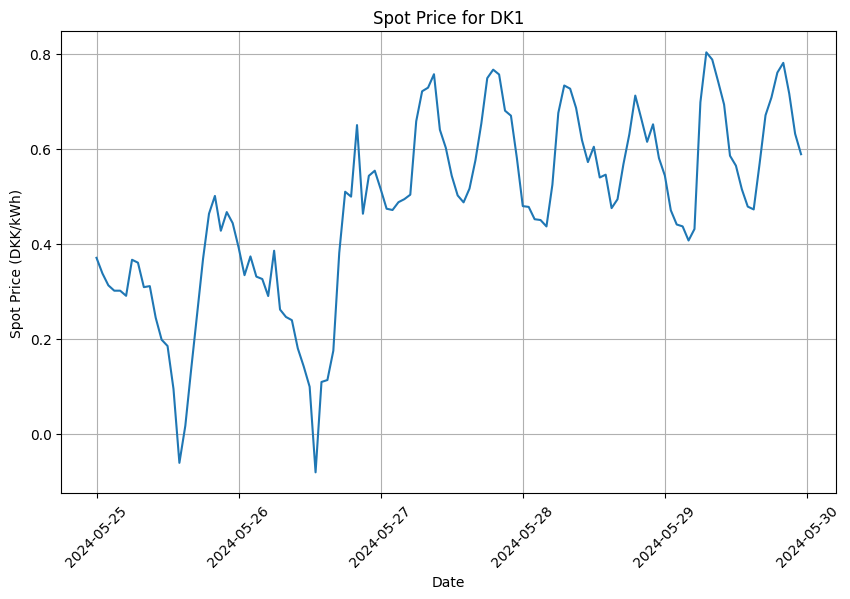

In [15]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = new_data.groupby('datetime')['predictions'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)

# Adding labels and title
plt.title('Spot Price for DK1')
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK/kWh)')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [16]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(new_data).mark_line(point=True).encode(
    x='datetime:T', 
    y='predictions:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('dateime:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('datetime:T', title='Time', format='%H:%M'), 
             alt.Tooltip('predictions:Q', title='Spot Price (DKK/kWh)', format='.2f'),
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our Python files for a Streamlit application ([link to Github repository](https://github.com/tobiasmj97/bds_m7_second-semester-project_streamlit)) </span>
